<a href="https://colab.research.google.com/github/cfong32/data6100-final-proj/blob/with-linear-fare-dist/data6100_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q --show-progress -O new-york-city-taxi-fare-prediction.zip https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ESnzvg-NHEhPgoURZmVYv1MBUS3GVlHGGUTbnBRS10J3Eg?download=1
!unzip new-york-city-taxi-fare-prediction.zip

new-york-city-taxi- 100%[===================>]   1.56G  88.3MB/s    in 20s     
Archive:  new-york-city-taxi-fare-prediction.zip
  inflating: GCP-Coupons-Instructions.rtf  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
import pytz
from datetime import datetime, timezone

pd.set_option('display.min_rows', 4)

# Read data (train + test)

In [3]:
# Helper function to calculate distance

def compute_dist(df):
    # source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    lat1 = df.pickup_latitude.map(np.deg2rad).values
    lon1 = df.pickup_longitude.map(np.deg2rad).values
    lat2 = df.dropoff_latitude.map(np.deg2rad).values
    lon2 = df.dropoff_longitude.map(np.deg2rad).values

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6373.0
    dist = R * c
    return dist

In [81]:
# Read dataset (train + test)

df = (
    pd.concat([
        (pd.read_csv('train.csv', nrows=1_000_000)    # read nrows ONLY, the whole set contains >55M rows
         .assign(dataset='train')),
        (pd.read_csv('test.csv')
         .assign(dataset='test')),
    ])
    .assign(
        pickup_datetime=lambda x: pd.to_datetime(x.pickup_datetime).dt.tz_convert('America/New_York'),
        year   =lambda x: x.pickup_datetime.dt.year,
        month  =lambda x: x.pickup_datetime.dt.month,
        weekday=lambda x: x.pickup_datetime.dt.weekday,
        hour   =lambda x: x.pickup_datetime.dt.hour,
        dist   =lambda x: compute_dist(x),
     )
)

print(f'# of rows: {df.dataset.value_counts().to_dict()}')
display(df)

# of rows: {'train': 1000000, 'test': 9914}


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset,year,month,weekday,hour,dist
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 13:26:21-04:00,-73.844311,40.721319,-73.841610,40.712278,1,train,2009,6,0,13,1.031088
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 11:52:16-05:00,-74.016048,40.711303,-73.979268,40.782004,1,train,2010,1,1,11,8.452786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,2015-01-31 01:05:19.0000005,NaN,2015-01-30 20:05:19-05:00,-73.985573,40.735432,-73.939178,40.801731,6,test,2015,1,4,20,8.346106
9913,2015-01-18 14:06:23.0000006,NaN,2015-01-18 09:06:23-05:00,-73.988022,40.754070,-74.000282,40.759220,6,test,2015,1,6,9,1.181196


In [82]:
# Simple description of train and test data

df.groupby('dataset').describe().stack()

fare_amount  pickup_longitude  pickup_latitude  \
dataset                                                            
test    count        0.000000       9914.000000      9914.000000   
        mean              NaN        -73.974722        40.751041   
        std               NaN          0.042774         0.033541   
        min               NaN        -74.252193        40.573143   
        25%               NaN        -73.992501        40.736125   
        50%               NaN        -73.982326        40.753051   
        75%               NaN        -73.968013        40.767113   
        max               NaN        -72.986532        41.709555   
train   count  1000000.000000    1000000.000000   1000000.000000   
        mean        11.348079        -72.526640        39.929008   
        std          9.822090         12.057937         7.626154   
        min        -44.900000      -3377.680935     -3116.285383   
        25%          6.000000        -73.992060        40.734965   
        50%          8.500000        -73.981792        40.752695   
        75%         12.500000        -73.967094        40.767154   
        max        500.000000       2522.271325      2621.628430   

               dropoff_longitude  dropoff_latitude  passenger_count  \
dataset                                                               
test    count        9914.000000       9914.000000      9914.000000   
        mean          -73.973657         40.751743         1.671273   
        std             0.039072          0.035435         1.278747   
        min           -74.263242         40.568973         1.000000   
        25%           -73.991247         40.735254         1.000000   
        50%           -73.980015         40.754065         1.000000   
        75%           -73.964059         40.768757         2.000000   
        max           -72.990963         41.696683         6.000000   
train   count      999990.000000     999990.000000   1000000.000000   
        mean          -72.527860         39.919954         1.684924   
        std            11.324494          8.201418         1.323911   
        min         -3383.296608      -3114.338567         0.000000   
        25%           -73.991385         40.734046         1.000000   
        50%           -73.980135         40.753166         1.000000   
        75%           -73.963654         40.768129         2.000000   
        max            45.581619       1651.553433       208.000000   

                         year           month         weekday            hour  \
dataset                                                                         
test    count     9914.000000     9914.000000     9914.000000     9914.000000   
        mean      2011.815312        6.861307        2.842243       12.404983   
        std          1.803435        3.353546        1.937365        6.031902   
        min       2009.000000        1.000000        0.000000        0.000000   
        25%       2010.000000        4.000000        1.000000        8.000000   
        50%       2012.000000        7.000000        3.000000       13.000000   
        75%       2014.000000       10.000000        5.000000       17.000000   
        max       2015.000000       12.000000        6.000000       23.000000   
train   count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
        mean      2011.740464        6.271553        2.983673       11.815118   
        std          1.860704        3.436769        1.906171        5.837268   
        min       2008.000000        1.000000        0.000000        0.000000   
        25%       2010.000000        3.000000        1.000000        7.000000   
        50%       2012.000000        6.000000        3.000000       12.000000   
        75%       2013.000000        9.000000        5.000000       17.000000   
        max       2015.000000       12.000000        6.000000       23.000000   

                        dist  
dataset                 

# Remove out-of-range data

In [83]:
def remove_out_of_range_records(df, cols=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']):
    trainset = df.dataset == 'train'
    testset  = df.dataset == 'test'

    testset_max = df[testset][cols].max()    # max values in test set
    testset_min = df[testset][cols].min()    # min values in test set

    trainset_to_drop = (trainset
                        &
                        ((df[cols] > testset_max).any(axis=1)     # > max
                         |
                         (df[cols] < testset_min).any(axis=1))    # or < min
                        )
    trainset_to_keep = trainset & ~trainset_to_drop

    return df[trainset_to_keep | testset]

df = remove_out_of_range_records(df)

print(f'# of rows: {df.dataset.value_counts().to_dict()}')
display(df)

# of rows: {'train': 975353, 'test': 9914}


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset,year,month,weekday,hour,dist
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 13:26:21-04:00,-73.844311,40.721319,-73.841610,40.712278,1,train,2009,6,0,13,1.031088
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 11:52:16-05:00,-74.016048,40.711303,-73.979268,40.782004,1,train,2010,1,1,11,8.452786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,2015-01-31 01:05:19.0000005,NaN,2015-01-30 20:05:19-05:00,-73.985573,40.735432,-73.939178,40.801731,6,test,2015,1,4,20,8.346106
9913,2015-01-18 14:06:23.0000006,NaN,2015-01-18 09:06:23-05:00,-73.988022,40.754070,-74.000282,40.759220,6,test,2015,1,6,9,1.181196


# Train a linear model --- $fare = \beta~dist + \gamma$

In [84]:
# Helper function to standardize X and y
def standardize_n_prepare_Xy(df, cols_X, col_y):
    trainset = df.dataset == 'train'
    testset  = df.dataset == 'test'

    # Make sure there is no NA
    assert df[trainset][cols_X].notna().all().all()
    assert df[trainset][col_y].notna().all().all()
    assert df[testset][cols_X].notna().all().all()
    
    # Standardize X_train and y_train
    sr_mean_X, sr_std_X = df[cols_X].mean(), df[cols_X].std()
    X_train = ((df[trainset][cols_X] - sr_mean_X) / sr_std_X).values
    y_train = df[trainset][col_y].values

    # Standardize X_test
    X_test = ((df[testset][cols_X] - sr_mean_X) / sr_std_X).values

    return X_train, y_train, X_test, sr_mean_X, sr_std_X


# Input and output variables
cols_X = ['dist']
col_y = 'fare_amount'
X_train, y_train, X_test, _, _ = standardize_n_prepare_Xy(df, cols_X, col_y)

X_train.shape, y_train.shape, X_test.shape

((975353, 1), (975353,), (9914, 1))

In [85]:
# Evaluate performnace using CV

model = LinearRegression()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-validation scores: [5.81537436 5.8555345  5.3113695  5.45411229 5.42955109]
Mean cross-validation score: 5.573188350637118


In [86]:
# Fit model

model.fit(X_train, y_train)
y_hat = model.predict(X_train)
y_residual = y_train - y_hat

beta = model.coef_[0]
gamma = model.intercept_
print(f'Model equation:')
print(f'fare_amount = dist * {beta} + {gamma}')

Model equation:
fare_amount = dist * 7.920863613606951 + 11.332889219925322


In [87]:
# Compute the linear prediction : 'lm_pred'
# also the residual             : 'lm_residual'

df.loc[df.dataset=='train', 'lm_pred'] = y_hat
df.loc[df.dataset=='train', 'lm_residual'] = y_residual
df.loc[df.dataset=='test' , 'lm_pred'] = model.predict(X_test)
display(df)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset,year,month,weekday,hour,dist,lm_pred,lm_residual
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 13:26:21-04:00,-73.844311,40.721319,-73.841610,40.712278,1,train,2009,6,0,13,1.031088,6.486884,-1.986884
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 11:52:16-05:00,-74.016048,40.711303,-73.979268,40.782004,1,train,2010,1,1,11,8.452786,22.134542,-5.234542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,2015-01-31 01:05:19.0000005,NaN,2015-01-30 20:05:19-05:00,-73.985573,40.735432,-73.939178,40.801731,6,test,2015,1,4,20,8.346106,21.909620,NaN
9913,2015-01-18 14:06:23.0000006,NaN,2015-01-18 09:06:23-05:00,-73.988022,40.754070,-74.000282,40.759220,6,test,2015,1,6,9,1.181196,6.803367,NaN


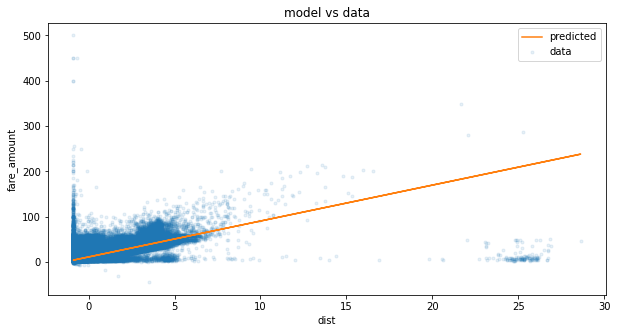

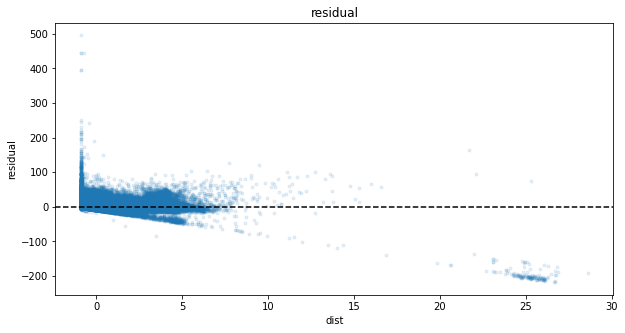

In [88]:
# Visualize performance of the linear model

plt.figure(figsize=(10,5))
plt.scatter(X_train, y_train, label='data', alpha=0.1, marker='.', color='C0')
plt.plot(X_train, y_hat, label='predicted', color='C1')
plt.title('model vs data')
plt.ylabel('fare_amount')
plt.xlabel('dist')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(X_train, y_residual, label='data', alpha=0.1, marker='.', color='C0')
plt.axhline(0, color='k', ls='--')
plt.title('residual')
plt.ylabel('residual')
plt.xlabel('dist')
plt.show()

# Train another model to predict the residual --- $residual = f(X)$

In [107]:
# Input and output variables
cols_X = [
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude',
    'passenger_count',
    'year',
    'month',
    'weekday',
    'hour',
]
col_y = 'lm_residual'
X_train, y_train, X_test, _, _ = standardize_n_prepare_Xy(df, cols_X, col_y)

X_train.shape, y_train.shape, X_test.shape

((975353, 9), (975353,), (9914, 9))

In [108]:
# Histogram-based Gradient Boosting Regression Tree
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor

# Evaluate performnace using CV

model = HistGradientBoostingRegressor()
scores = -cross_val_score(model,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

print('5-fold cross-validation scores:', scores)
print('Mean cross-validation score:', np.mean(scores))

5-fold cross-validation scores: [4.32467666 4.51748387 3.99687148 3.90906309 4.05642641]
Mean cross-validation score: 4.160904301787943


In [112]:
# Fit model

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)
y_hat = model.predict(X_train)


# Compute the overall prediction : 'total_pred' = 'lm_pred' + 'res_pred'

df.loc[df.dataset=='train', 'res_pred'] = y_hat
df.loc[df.dataset=='test' , 'res_pred'] = model.predict(X_test)
df['total_pred'] = df['lm_pred'] + df['res_pred']
display(df)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dataset,year,month,weekday,hour,dist,lm_pred,lm_residual,res_pred,total_pred
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 13:26:21-04:00,-73.844311,40.721319,-73.841610,40.712278,1,train,2009,6,0,13,1.031088,6.486884,-1.986884,0.939746,7.426630
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 11:52:16-05:00,-74.016048,40.711303,-73.979268,40.782004,1,train,2010,1,1,11,8.452786,22.134542,-5.234542,-2.495663,19.638879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9912,2015-01-31 01:05:19.0000005,NaN,2015-01-30 20:05:19-05:00,-73.985573,40.735432,-73.939178,40.801731,6,test,2015,1,4,20,8.346106,21.909620,NaN,-0.997653,20.911967
9913,2015-01-18 14:06:23.0000006,NaN,2015-01-18 09:06:23-05:00,-73.988022,40.754070,-74.000282,40.759220,6,test,2015,1,6,9,1.181196,6.803367,NaN,0.460907,7.264274


In [116]:
# Evalulate the overall RMSE on the training set

df_train = df[df.dataset=='train']
true = df_train['fare_amount'].values
pred = df_train['total_pred'].values
rmse = ((true-pred)**2).mean()**0.5

print(f'Overall RMSE: {rmse}')

Overall RMSE: 4.0393181692404


# Make a submission CSV

In [115]:
import pytz
from datetime import datetime, timezone

# make submission csv
df_submission = pd.DataFrame({
    'key'        : df[df.dataset=='test']['key'],
    'fare_amount': df[df.dataset=='test']['total_pred'],
})

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")
save_path = f'submission.{timestr}.csv'
df_submission.to_csv(save_path, index=False)
print('saved to', save_path)

saved to submission.2212140023.csv


# Keep some records (for ourselves)

- LMRES.submission.2212140023.csv
    1. Using **linear Model** to predict `'fare_amount'` by `'dist'`
    2. Then using **HBGR** to predict the residual by other 9 features
        - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'weekday', 'hour']`
    3. Combine both results
    - Score: **3.35712**
- HBGR.submission.2211271646.csv
    - **Histogram-based Gradient Boosting Regression Tree**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Score: **3.79107**
- LR.submission.2212271557.csv
    - **Simple linear regression**
    - Input features = `['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'weekday', 'hour', 'minute']`
    - Score: **7.93275**

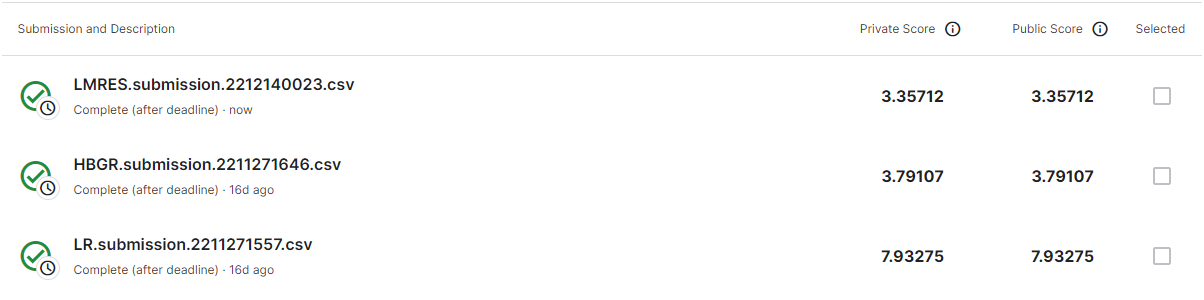